In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

In [101]:
# # effect size tables # #
#FDR - 0.05
mcll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a4.20230115_effect_sizes.txt",sep=' ')
ucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a6.20230115_effect_sizes.txt",sep=' ')
mucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a2.20230115_effect_sizes.txt",sep=' ')

In [102]:
# # junction column, cll column # #
table = pd.merge(mcll[['intron','unmut','mut','deltapsi']],ucll[['intron','unmut','mut','deltapsi']], how='outer')
table=pd.merge(table, mucll[['intron','unmut','mut','deltapsi']], how='outer')
table['analysis_set'] = None
table.loc[table['intron'].isin(mcll['intron']), 'analysis_set'] = 'm'
table.loc[table['intron'].isin(ucll['intron']), 'analysis_set'] = 'u'
table.loc[table['intron'].isin(mucll['intron']),'analysis_set' ] = 'mu' #TODO only m/u?
#table.rename({'intron':'junction'},inplace=True)
table[['junction','cluster']]=table['intron'].str.rsplit(':',expand=True,n=1)
# table.drop(columns='intron',inplace=True)
# table = table.reindex(columns=['junction','analysis_set','cluster'])

In [103]:
# # cluster significance # # 
#FDR - 0.05
mcll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a4.20230115_cluster_significance.txt",sep=' ')
ucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a6.20230115_cluster_significance.txt",sep=' ')
mucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a2.20230115_cluster_significance.txt",sep=' ')

In [104]:
# merge cluster significance tables #
cluster_table=pd.merge(mcll[['cluster','p.adjust']],ucll[['cluster','p.adjust']],on='cluster',how='outer',suffixes=['_m','_u'])
cluster_table=cluster_table.merge(mucll[['cluster','p.adjust']],on='cluster',how='outer')
cluster_table['cluster']=cluster_table['cluster'].str.rsplit(':',expand=True,n=1)[1]

In [105]:
# merge table with cluster table #
table=table.merge(cluster_table,how='left',on='cluster')

In [106]:
# add chrom column #
table["chrom"]=table['intron'].str.rsplit(':',expand=True,n=3)[0]
table["chrom"]=table["chrom"].str.replace('chr','')

In [107]:
# loading gtf file- only protein coding #
import pyensembl
table['gene_name']=pd.NaT
# table['identified']=pd.NaT
data = pyensembl.Genome(
    reference_name='GRCh37',
    annotation_name='my_genome_lab',
    gtf_path_or_url='/home/ls/rachelcw/projects/protein_coding.gtf')
data.index()


In [108]:
# gene name per junction #
for i,j in enumerate(table.junction):
    j=j.split(':')
    chr=j[0].replace('chr','')
    start=int(j[1])
    end=int(j[2])
    gene_name = data.gene_names_at_locus(contig=chr, position=start,end=end)
    if gene_name != []:
        table.at[i,'gene_name']=gene_name
    

table.dropna(subset=['gene_name'], inplace=True)


In [ ]:
all_intron=pd.read_csv("/home/ls/rachelcw/projects/BIO/annontation_code.20221225_fiveprime.bed.gz", sep='\t',compression='gzip', header=None,usecols=[0,1,2,3,5,8] ,names=['chrom', 'start','end','gene_name', 'strand','type'])
all_intron['chrom'] = all_intron['chrom'].astype(str)
intron_list=all_intron["gene_name"].unique()

In [110]:
# filter out when unmut bigger than mut (deltapsi < 1) #
table.rename(columns={'p.adjust':'p.adjust_mu'},inplace=True)
table = table[table.deltapsi > 0] # mut-unmut >1

In [111]:
# for duplicates juction save only the junction with the highest deltapsi #
table=table.sort_values('deltapsi', ascending=False)
table.drop_duplicates(subset='intron',keep='first', inplace=True)
table=table.reset_index()

In [112]:
# reads count per juction #
counts_read=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/lc_20230108/lc_20230108_perind_numers.counts.gz", sep=' ',compression='gzip')

In [113]:
junction_list=table["intron"].str.replace("chr","").values
counts_junction=counts_read.loc[counts_read.index.isin(junction_list)]


In [114]:
counts=[np.sum(x) for x in counts_junction.values]
counts_table=pd.DataFrame({"counts":counts},index=counts_junction.index)
table["intron"]=table["intron"].str.replace("chr","")
table=table.merge(counts_table,how="left",left_on="intron",right_index=True)

In [10]:
# table.to_csv("/home/ls/rachelcw/projects/BIO/table.20230123.csv",index=0)

table_p=pd.read_csv("/home/ls/rachelcw/projects/BIO/table.20230123.csv")

In [116]:
# the junction (event) is identified in GTF (known 5, known 3, known junction, novel), add strand column (+\-) #
fiveprime=pd.read_csv("/home/ls/rachelcw/projects/BIO/annontation_code.20221225_fiveprime.bed.gz", sep='\t',compression='gzip', header=None,usecols=[0,1,5,8] ,names=['chrom', 'start_int',  'strand','type'])
fiveprime['chrom'] = fiveprime['chrom'].astype(str)
fiveprime= fiveprime.loc[(fiveprime.type=='protein_coding')]
threeprime=pd.read_csv("/home/ls/rachelcw/projects/BIO/annontation_code.20221225_threeprime.bed.gz", sep='\t',compression='gzip', header=None, usecols=[0,1,5,8] ,names=['chrom', 'start_int',  'strand','type'])
threeprime['chrom'] = threeprime['chrom'].astype(str)
threeprime= threeprime.loc[(threeprime.type=='protein_coding')]
table['identified_gtf']=pd.NaT
table['strand']= pd.NaT

for chr in fiveprime.chrom.unique():
    fiveprime_chr=fiveprime.loc[fiveprime.chrom==chr]
    threeprime_chr=threeprime.loc[threeprime.chrom==chr]
    chr_table=table.loc[table.chrom==chr]
    for junc in chr_table.junction:
        junction=junc.split(':')
        # chr=junction[0].replace('chr','')
        start=int(junction[1])
        end=int(junction[2])
        identified= ""
        counter = 0
        if fiveprime_chr['start_int'].isin([start]).any():
            identified= "known 5'"
            counter = counter +1
            strand=list(fiveprime_chr.loc[fiveprime_chr.start_int==start,'strand'])[0]
            table.loc[table.junction==junc,'strand']=strand
        if threeprime_chr['start_int'].isin([end]).any():
            identified= "known 3'"
            counter = counter +1
            strand=list(threeprime_chr.loc[threeprime_chr.start_int==end,'strand'])[0]
            table.loc[table.junction==junc,'strand']= strand
        if counter == 2:
            identified = "known junction"
        if counter == 0:
            identified = "novel"
        table.loc[table.junction==junc,'identified_gtf']=identified
          

/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[Text(0, 0, '2788'), Text(0, 0, '524'), Text(0, 0, '1286')]

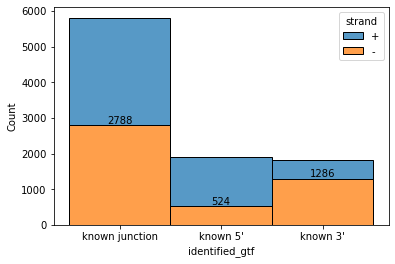

In [23]:
plot_table=table.filter(items=["intron","identified_gtf","strand"])
# plot_table.drop_duplicates(inplace=True)
ax=sns.histplot(data=plot_table, x='identified_gtf',hue='strand',multiple="stack")
# ax=sns.histplot(data=plot_table, x='identified gtf')
ax.bar_label(ax.containers[0])

In [ ]:
table["cluster"].value_counts().value_counts()

In [117]:
# table of 5/3 known events #
table_altss=table[table["identified_gtf"].str.contains("\d")]

In [119]:
table_altss=table_altss.reset_index()
table_altss["gene_by_strand"]= pd.NaT
for i,j in zip(table_altss["junction"].index,table_altss["junction"]):
    j=j.split(':')
    chr=j[0].replace('chr','')
    start=int(j[1])
    end=int(j[2])
    strand=table_altss["strand"].iloc[i]
    gene_name = data.gene_names_at_locus(contig=chr, position=start,end=end,strand=strand)
    table_altss.at[i,'gene_by_strand']=gene_name
    

In [120]:
# annotation column #
table_altss['annotation']=pd.NaT
table_altss['donor/acceptor']=pd.NaT

# alternative 5 / 3 splice site- known only one prime
# known 3' #
condition = re.compile("3")
table_altss.loc[table_altss['identified_gtf'].str.contains(condition),'donor/acceptor']="donor"
table_altss.loc[(table_altss['identified_gtf'].str.contains(condition))&(table_altss['strand'].str.contains("\\+")),'annotation']="A5SS"
table_altss.loc[(table_altss['identified_gtf'].str.contains(condition))&(table_altss['strand'].str.contains("-")),'annotation']="A3SS"

# known 5' #
condition = re.compile("5")
table_altss.loc[table_altss['identified_gtf'].str.contains(condition),'donor/acceptor']="acceptor"
table_altss.loc[(table_altss['identified_gtf'].str.contains(condition))&(table_altss['strand'].str.contains("\\+")),'annotation']="A3SS" 
table_altss.loc[(table_altss['identified_gtf'].str.contains(condition))&(table_altss['strand'].str.contains("-")),'annotation']="A5SS" 




In [121]:
# frameshift #
table_altss['frameshift']=pd.NaT
for junc in table_altss.junction:
    junction=junc.split(':')
    start=int(junction[1])
    end=int(junction[2])
    size=end-start
    if size%3==0:
        table_altss.loc[table_altss.junction==junc,'frameshift']="0"
    else:
        table_altss.loc[table_altss.junction==junc,'frameshift']="1"

table_altss['frameshift'].value_counts()
# table of no frameshift events #
no_frameshift=table_altss[table_altss["frameshift"].str.contains("0")]

In [122]:
# essential gene #
# gene_dep=pd.read_csv("/home/ls/rachelcw/projects/CRISPR_gene_dependency.csv")
essential_gene=pd.read_csv("/home/ls/rachelcw/projects/CRISPRInferredCommonEssentials.csv")
pattern=re.compile("\\(*\d*\\)")
essential_gene["Essentials"]=essential_gene["Essentials"].str.replace(pattern,'')
essential_gene["Essentials"]=essential_gene["Essentials"].str.replace(" ",'')
essential_gene_list=essential_gene["Essentials"].to_list()

In [123]:
no_frameshift["essential"]=pd.NaT
for i,gene in zip(no_frameshift["gene_by_strand"].index,no_frameshift["gene_by_strand"]):
    esn=""
    if len(gene)>1:
        no_frameshift.loc[i,"essential"]="check"
    else:
        
        if gene[0] in essential_gene_list:
            no_frameshift.loc[i,"essential"]="1"
        else:
            no_frameshift.loc[i,"essential"]="0"

/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [128]:
essential_no_frameshift=no_frameshift[no_frameshift["essential"].str.contains("1")]
essential_no_frameshift=essential_no_frameshift.drop(columns=["index","level_0"])

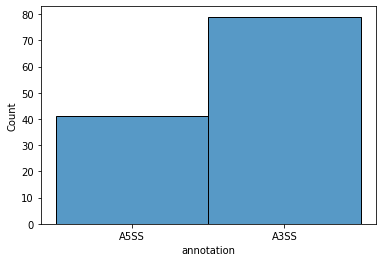

In [26]:
ax=sns.histplot(data=essential_no_frameshift, x='annotation')

In [89]:
f = open("/private1/private/resources/gencode19_noChrPrefix_mitoMT.gtf", "r")
line = f.readlines()
lines = list()
for l in line:
    if not l.startswith('#'):
        lines.append(l) # 2,619,444
clean = [l.replace(';', '\t') for l in lines] # get rid of ;
clean = [l.split('\t') for l in clean] # get rid of \t
clean_data = [row[0:13] for row in clean] # cut columns
# input to df
gtf_data = pd.DataFrame(clean_data, columns=["chr", "source", "feature_type", "start", "end", "score ","strand", "phase", "gene_id", "transcript_id", "gene_type","gene_status","gene_name"])
gtf_data = gtf_data[gtf_data.feature_type=="gene"] # 57,820 genes
gtf_data = gtf_data.loc[gtf_data["gene_type"].str.contains("protein_coding")] # 20,345 protein_coding genes
# get ENS names
for i, gene in enumerate(gtf_data.gene_id): # values in col
    gtf_data.gene_id.iloc[i] = gtf_data.gene_id.iloc[i].replace('gene_id','')
 # 20,345


In [108]:
protein_coding_genes = gtf_data["gene_name"].str.replace(" gene_name ","")  # 20,345
protein_coding_genes = [name[1:-1] for name in protein_coding_genes] 
protein_coding_genes[1]

'AL627309.1'

In [ ]:
sns.barplot(x=gene_dep.mean())
# ax=sns.distplot(gene_dep.mean())

In [32]:
exons=pd.read_csv("/private1/private/resources/bedfile_from_gtf/annontation_code.20221225_all_exons.txt.gz", sep='\t',compression='gzip')

In [ ]:
# skipped exon #
condition = re.compile("known junction")
index=table[table['identified gtf'].str.contains(condition)].index
table_known=table.loc[index]

# exon=pd.read_csv("/private1/private/resources/bedfile_from_gtf/annontation_code.20221225_all_exons.txt.gz",sep='\t',compression='gzip')
for j in table_known.junction:
    junction=junc.split(':')
    chr=junction[0].replace('chr','')
    start=int(junction[1])
    end=int(junction[2])
    annotation=""
    for exon in data.exons_at_locus(chr,start,end=end):

